## Uppgift 8
###  I denna uppgift arbetar vi med CIFAR-100 datasetet som gicks igenom i kodexempel 1.
  #### a) Skapa en CNN-modell för att prediktera datasetet.
  #### b) Om du justerar hyperparametrar med KerasTuner, får du bättre resultat?
  #### c) Prova använd transfer learning för att genomföra prediktioner, får du bättre resultat?

#### a)

In [1]:
# Importerar bibliotek
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Keras och tensorflow
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

##### Ladda in och förbered cifar 100 datan

In [2]:
# Ladda in cifar 100 datasetet
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()

# Visa datasetet shape innan uppdelning
print("X_train_full:", X_train_full.shape)
print("X_test:", X_test.shape)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
X_train_full: (50000, 32, 32, 3)
X_test: (10000, 32, 32, 3)


In [3]:
# Dela upp träningsdatan i träningsdata och valideringsdata
# De första 5000 bilderna används som valideringsdata
# Vi normaliserar pixlarna till intervallet 0-1 genom att dividera med 255.0
X_train, X_valid = X_train_full[5000:] / 255.0, X_train_full[:5000] / 255.0
y_train, y_valid = y_train_full[5000:], y_train_full[:5000]

# Normaliserar även testdatan
X_test = X_test / 255.0

# Visar shapes efter uppdelning
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test:", X_test.shape)

X_train: (45000, 32, 32, 3)
X_valid: (5000, 32, 32, 3)
X_test: (10000, 32, 32, 3)


##### Visualisera några bilder från datasetet

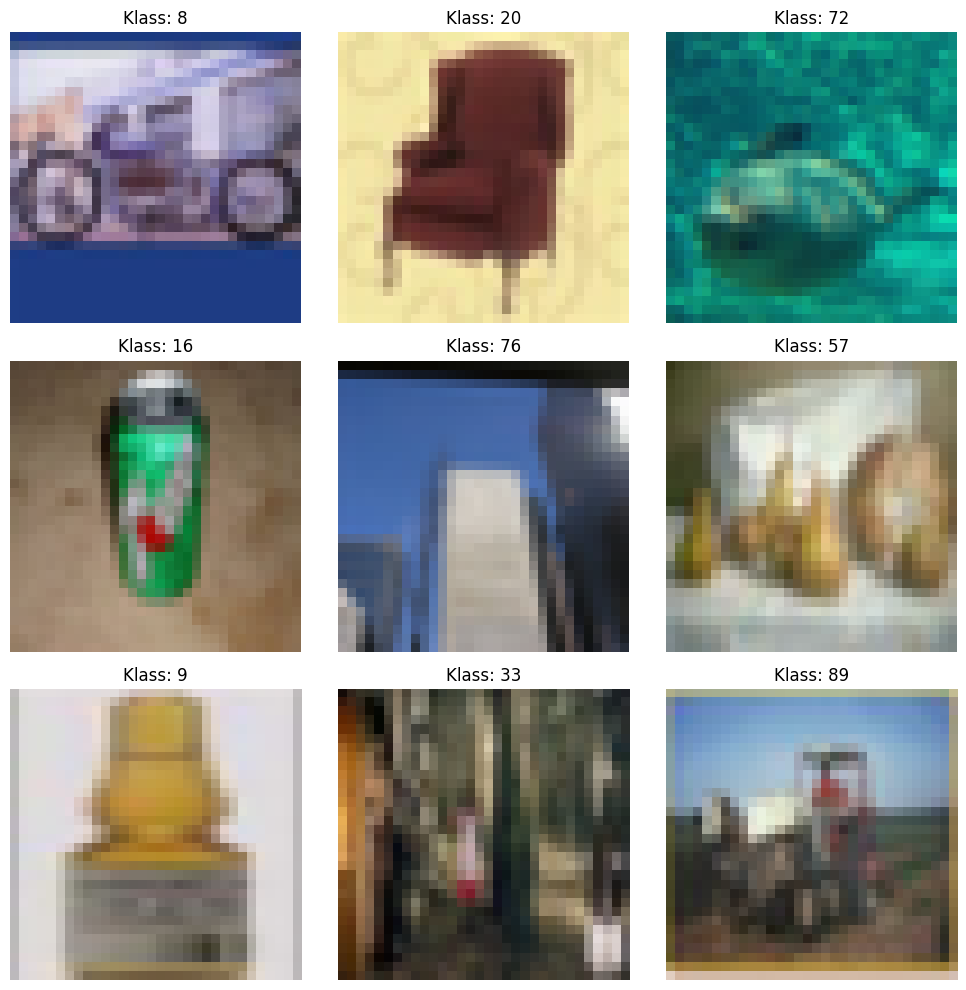

In [4]:
# Visualisera 9 bilder i ett 3x3 rutnät för att se hur datan ser ut
# cifar 100 bilder är i färg (RGB) till skillnad från MNIST som var gråskala
plt.figure(figsize=(10, 10))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)
    plt.imshow(X_train[i])  # Färgbilder 
    plt.title(f"Klass: {y_train[i][0]}")  # Visa klassnumret
    plt.axis('off')
plt.tight_layout()
plt.show()

##### Bygga CNN modellen

In [5]:
# Skapa en Sequential modell (CNN)
model = Sequential()

# Specificera inputshape: bilderna är 32x32 pixlar med 3 kanaler (RGB)
model.add(Input(shape=(32, 32, 3)))

# Första convolution lagret: 32 filter med storlek 3x3, padding='same' behåller bildstorleken
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
# Max pooling minskar bildstorleken till hälften (16x16)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Andra convolution lagret: 64 filter, fler filter kompenserar för minskad bildstorlek
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
# Max pooling minskar bildstorleken till (8x8)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tredje convolution lagret: 128 filter
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
# Max pooling minskar bildstorleken till (4x4)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fjärde convolution lagret: 256 filter
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
# Max pooling minskar bildstorleken till (2x2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten gör om 2D bilderna till 1D som de täta lagren förväntar sig
model.add(Flatten())

# Dropout med 50% för att motverka överanpassning (regularisering)
model.add(Dropout(0.5))

# Tätt dolt lager med 512 noder och relu aktiveringsfunktion
model.add(Dense(512, activation='relu'))

# Output lagret: 100 noder (en per klass i cifar 100) med softmax för sannolikheter
model.add(Dense(100, activation='softmax'))

# Visa en summering av modellens arkitektur och antal parametrar
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 964,516 (3.68 MB)

 Trainable params: 964,516 (3.68 MB)

 Non-trainable params: 0 (0.00 B)

##### Kompilera och träna modellen

In [6]:
# Kompilera modellen
# sparse_categorical_crossentropy används eftersom våra y värden inte är one hot encoded
# accuracy används som utvärderingsmått
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Earlystopping stoppar träningen om val_loss inte förbättras på 3 epoker
# restore_best_weights=True återställer vikterna från den bästa epoken
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Träna modellen i 20 epoker med valideringsdata
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid),
                    callbacks=[early_stop], verbose=2)

Epoch 1/20
1407/1407 - 11s - 7ms/step - accuracy: 0.0876 - loss: 3.9721 - val_accuracy: 0.1412 - val_loss: 3.6348
Epoch 2/20
1407/1407 - 9s - 7ms/step - accuracy: 0.2002 - loss: 3.2972 - val_accuracy: 0.2022 - val_loss: 3.2933
Epoch 3/20
1407/1407 - 10s - 7ms/step - accuracy: 0.2655 - loss: 2.9640 - val_accuracy: 0.2504 - val_loss: 3.1477
Epoch 4/20
1407/1407 - 9s - 7ms/step - accuracy: 0.3104 - loss: 2.7336 - val_accuracy: 0.3238 - val_loss: 2.6917
Epoch 5/20
1407/1407 - 9s - 7ms/step - accuracy: 0.3428 - loss: 2.5764 - val_accuracy: 0.3000 - val_loss: 2.7636
Epoch 6/20
1407/1407 - 10s - 7ms/step - accuracy: 0.3692 - loss: 2.4651 - val_accuracy: 0.3112 - val_loss: 2.8239
Epoch 7/20
1407/1407 - 10s - 7ms/step - accuracy: 0.3884 - loss: 2.3620 - val_accuracy: 0.3516 - val_loss: 2.6355
Epoch 8/20
1407/1407 - 10s - 7ms/step - accuracy: 0.4046 - loss: 2.2935 - val_accuracy: 0.3320 - val_loss: 2.6365
Epoch 9/20
1407/1407 - 10s - 7ms/step - accuracy: 0.4157 - loss: 2.2500 - val_accuracy: 0.3

##### Visualisera träningshistorik

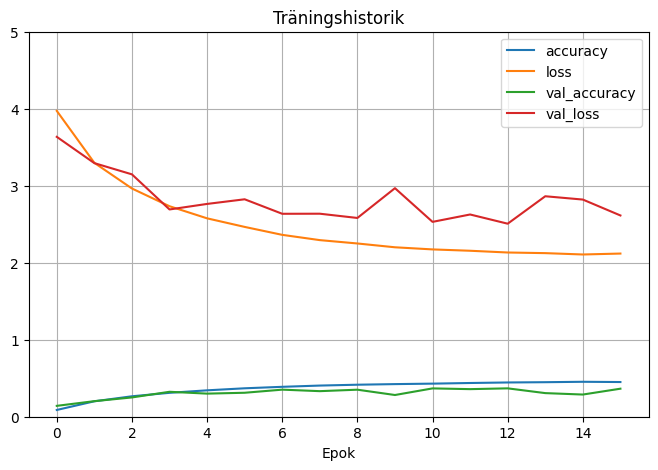

In [7]:
# Visualiserar hur loss och accuracy utvecklas under träningen
# history.history innehåller loss, accuracy, val_loss och val_accuracy för varje epok
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.title("Träningshistorik")
plt.xlabel("Epok")
plt.show()

##### Evaluera modellen på testdata

In [8]:
# Evaluerar modellen på testdatan som modellen aldrig sett under träningen
# Detta ger oss en uppskattning av hur modellen presterar på ny osedd data
model.evaluate(X_test, y_test, verbose=2)

313/313 - 1s - 3ms/step - accuracy: 0.3753 - loss: 2.4465


[2.4465088844299316, 0.37529999017715454]

In [9]:
# Ta 3 bilder från testdatan och prediktera dem
X_new = X_test[:3]

# Modellen predikterar sannolikheter för varje klass (0-99)
y_proba = model.predict(X_new, verbose=2)
print("Sannolikheter (avrundat, topp 5 per bild):")
for i in range(3):
    top5 = np.argsort(y_proba[i])[-5:][::-1]
    print(f"Bild {i+1}: {[(k, round(y_proba[i][k], 3)) for k in top5]}")

# Väljer den klass med högst sannolikhet som slutgiltig prediktion
classes_x = np.argmax(y_proba, axis=1)

# Jämför predikterade klasser med de sanna klasserna
print(f"\nPredikterade klasser: {classes_x}")
print(f"Sanna klasser:       {y_test[:3].flatten()}")

1/1 - 0s - 53ms/step
Sannolikheter (avrundat, topp 5 per bild):
Bild 1: [(np.int64(44), np.float32(0.165)), (np.int64(79), np.float32(0.108)), (np.int64(27), np.float32(0.041)), (np.int64(93), np.float32(0.037)), (np.int64(8), np.float32(0.037))]
Bild 2: [(np.int64(38), np.float32(0.264)), (np.int64(33), np.float32(0.235)), (np.int64(31), np.float32(0.19)), (np.int64(97), np.float32(0.052)), (np.int64(80), np.float32(0.041))]
Bild 3: [(np.int64(27), np.float32(0.177)), (np.int64(55), np.float32(0.157)), (np.int64(93), np.float32(0.078)), (np.int64(4), np.float32(0.067)), (np.int64(72), np.float32(0.049))]

Predikterade klasser: [44 38 27]
Sanna klasser:       [49 33 72]


#### b)

##### Importera KerasTuner

In [10]:
# Importerar kerastuner för hyperparameteroptimering
from keras_tuner import RandomSearch

##### Definiera build_model funktionen för kerastuner

In [11]:
# Definierar en funktion som kerastuner använder för att bygga CNN modeller
# med olika hyperparametrar. hp-objektet låter oss definiera sökrymden.
def build_model(hp):
    nn_model = Sequential()
    nn_model.add(Input(shape=(32, 32, 3)))

    # Tune antal Conv2D+MaxPooling block (mellan 2 och 4)
    for i in range(hp.Int('num_conv_blocks', min_value=2, max_value=4)):
        # Tune antal filter i varje Conv2D-lager (32, 64, 128 eller 256)
        hp_filters = hp.Choice(f'filters_{i}', values=[32, 64, 128, 256])
        nn_model.add(Conv2D(hp_filters, kernel_size=(3, 3), padding='same', activation='relu'))
        nn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten gör om 2D till 1D
    nn_model.add(Flatten())

    # Tune om dropout ska användas efter Flatten
    if hp.Boolean("dropout"):
        hp_dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5])
        nn_model.add(Dropout(rate=hp_dropout_rate))

    # Tune antal noder i det täta dolda lagret (mellan 128 och 512, steg om 64)
    hp_units = hp.Int('dense_units', min_value=128, max_value=512, step=64)
    nn_model.add(Dense(units=hp_units, activation='relu'))

    # Output lagret: 100 noder med softmax (en per klass i CIFAR 100)
    nn_model.add(Dense(100, activation='softmax'))

    # Kompilera modellen med adam och sparse_categorical_crossentropy
    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return nn_model

##### Kör kerastuner

In [12]:
# Skapar en randomsearch tuner som testar olika hyperparameterkombinationer
# objective='val_accuracy' innebär att vi vill maximera accuracy på valideringsdata
# max_trials=10 innebär att 10 olika kombinationer testas
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    overwrite=True,
)

# Earlystopping stoppar träningen om valideringsfelet inte förbättras på 2 epoker
early_stopping_monitor = EarlyStopping(patience=2)

# Kör sökningen: testar olika hyperparametrar och tränar varje modell i 20 epoker
tuner.search(X_train, y_train, validation_split=0.2, epochs=20, callbacks=[early_stopping_monitor], verbose=2)

# Visar en sammanfattning av resultaten
tuner.results_summary()

Trial 10 Complete [00h 01m 18s]
val_accuracy: 0.33399999141693115

Best val_accuracy So Far: 0.40844443440437317
Total elapsed time: 00h 23m 55s
Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_conv_blocks: 3
filters_0: 32
filters_1: 64
dropout: True
dense_units: 256
filters_2: 128
filters_3: 32
dropout_rate: 0.4
Score: 0.40844443440437317

Trial 08 summary
Hyperparameters:
num_conv_blocks: 2
filters_0: 64
filters_1: 32
dropout: True
dense_units: 256
filters_2: 32
filters_3: 128
dropout_rate: 0.4
Score: 0.37522223591804504

Trial 07 summary
Hyperparameters:
num_conv_blocks: 3
filters_0: 128
filters_1: 128
dropout: True
dense_units: 384
filters_2: 32
filters_3: 64
dropout_rate: 0.4
Score: 0.37077778577804565

Trial 04 summary
Hyperparameters:
num_conv_blocks: 2
filters_0: 64
filters_1: 64
dropout: False
dense_units: 448
filters_2: 128
filters_3: 64
dropout_rate: 0.4
Score: 0.356444

##### Träna bästa modellen vidare

In [13]:
# Hämtar den bästa modellen som kerastuner hittade
tuned_model = tuner.get_best_models(num_models=1)[0]
tuned_model.build()

# Träna den bästa modellen vidare med fler epoker och earlystopping
# EarlyStopping avslutar träningen om val_loss inte förbättras på 3 epoker
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Använder epochs=20 för en rättvis jämförelse med del a)
tuned_model.fit(X_train, y_train, validation_split=0.2, epochs=20,
                callbacks=[early_stop], verbose=2)

c:\Users\edrin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
1125/1125 - 7s - 6ms/step - accuracy: 0.5460 - loss: 1.6240 - val_accuracy: 0.4001 - val_loss: 2.4467
Epoch 2/20
1125/1125 - 6s - 5ms/step - accuracy: 0.5608 - loss: 1.5500 - val_accuracy: 0.4016 - val_loss: 2.4882
Epoch 3/20
1125/1125 - 6s - 5ms/step - accuracy: 0.5805 - loss: 1.4857 - val_accuracy: 0.3932 - val_loss: 2.4966
Epoch 4/20
1125/1125 - 6s - 5ms/step - accuracy: 0.5922 - loss: 1.4199 - val_accuracy: 0.4020 - val_loss: 2.4966


##### Evaluera den optimerade modellen på testdata

In [15]:
# Evaluera den optimerade modellen på testdatan
# Jämför detta resultat med resultatet från del a) för att se om det blev bättre
print("Resultat för den kerastuner optimerade modellen:")
tuned_model.evaluate(X_test, y_test, verbose=2)

Resultat för den kerastuner optimerade modellen:
313/313 - 1s - 2ms/step - accuracy: 0.4103 - loss: 2.4161


[2.416088104248047, 0.41029998660087585]

#### c)

##### Importera för transfer learning

In [16]:
# Importera MobileNetV2 som är en förtränad modell tränad på ImageNet
from tensorflow.keras.applications import MobileNetV2

##### Förbered data för transfer learning

In [17]:
# MobileNetV2 kräver minst 96x96 pixlar som input
# Vi skapar om bilderna till 128x128 (samma som i boken)
X_train_resized = tf.image.resize(X_train, (128, 128))
X_test_resized = tf.image.resize(X_test, (128, 128))

print("X_train_resized:", X_train_resized.shape)
print("X_test_resized:", X_test_resized.shape)

X_train_resized: (45000, 128, 128, 3)
X_test_resized: (10000, 128, 128, 3)


##### Bygg transfer learning modellen

In [18]:
# Ladda in MobileNetV2 utan det översta lagret (include_top=False)
# weights='imagenet' innebär att vikterna är förtränade på imagenet datasetet
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Frys vikterna i den förtränade modellen så de inte uppdateras under träning
# De nedre lagren fångar generella mönster som kan återanvändas
base.trainable = False

# Bygg den nya modellen med den förtränade basen
# Vi lägger till Flatten och ett output-lager med 100 noder 
transfer_model = Sequential([
    base,                                  # Den förtränade mobilenetv2 som bas
    Flatten(),                             # Plattar ut till 1D
    Dense(100, activation='softmax')       # Output: 100 klasser med softmax
])

# Visa modellens arkitektur
transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     2,048,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,306,084 (16.43 MB)

 Trainable params: 2,048,100 (7.81 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

##### Träna och evaluera transfer learning modellen

In [19]:
# Kompilera transfer learning modellen
transfer_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Träna modellen i 5 epoker (samma som i boken)
# validation_split=0.2 delar automatiskt av 20% av träningsdatan som valideringsdata
transfer_model.fit(X_train_resized, y_train, epochs=5, validation_split=0.2, verbose=2)

Epoch 1/5
1125/1125 - 67s - 59ms/step - accuracy: 0.3817 - loss: 8.3322 - val_accuracy: 0.4210 - val_loss: 9.0494
Epoch 2/5
1125/1125 - 68s - 61ms/step - accuracy: 0.5770 - loss: 5.1647 - val_accuracy: 0.4868 - val_loss: 7.7266
Epoch 3/5
1125/1125 - 70s - 62ms/step - accuracy: 0.6647 - loss: 3.6298 - val_accuracy: 0.5027 - val_loss: 8.0400
Epoch 4/5
1125/1125 - 69s - 61ms/step - accuracy: 0.7327 - loss: 2.6261 - val_accuracy: 0.4652 - val_loss: 10.0483
Epoch 5/5
1125/1125 - 66s - 59ms/step - accuracy: 0.7857 - loss: 1.9678 - val_accuracy: 0.4974 - val_loss: 9.3201


In [20]:
# Evaluera transfer learning modellen på testdatan
print("Resultat för transfer learning modellen:")
transfer_model.evaluate(X_test_resized, y_test, verbose=2)

Resultat för transfer learning modellen:
313/313 - 15s - 48ms/step - accuracy: 0.5013 - loss: 9.1130


[9.113015174865723, 0.5012999773025513]

##### Jämförelse av resultaten

In [21]:
# Evaluera alla tre modellerna på testdatan för att jämföra
loss_a, accuracy_a = model.evaluate(X_test, y_test, verbose=0)
loss_b, accuracy_b = tuned_model.evaluate(X_test, y_test, verbose=0)
loss_c, accuracy_c = transfer_model.evaluate(X_test_resized, y_test, verbose=0)

# Skapa en tabell med resultaten för enkel jämförelse
resultat = pd.DataFrame({
    "Modell": ["a) CNN (32-64-128-256)", "b) Kerastuner optimerad", "c) Transfer learning (MobileNetV2)"],
    "Test Accuracy": [f"{accuracy_a:.4f}", f"{accuracy_b:.4f}", f"{accuracy_c:.4f}"],
    "Test Loss": [f"{loss_a:.4f}", f"{loss_b:.4f}", f"{loss_c:.4f}"]
})
print(resultat.to_string(index=False))

# Hitta bästa modellen
accuracies = {'a) CNN': accuracy_a, 'b) Kerastuner': accuracy_b, 'c) Transfer learning': accuracy_c}
best = max(accuracies, key=accuracies.get)
print(f"\nBäst resultat: {best} med accuracy {accuracies[best]:.4f}")

                            Modell Test Accuracy Test Loss
            a) CNN (32-64-128-256)        0.3753    2.4465
           b) Kerastuner optimerad        0.4103    2.4161
c) Transfer learning (MobileNetV2)        0.5013    9.1130

Bäst resultat: c) Transfer learning med accuracy 0.5013


##### Sammanfattning

I **del a)** byggde vi en CNN modell med arkitekturen från boken (Conv2D + MaxPooling2D lager med 32, 64, 128 och 256 filter) och tränade den på CIFAR 100 datan.

I **del b)** använde vi kerastuner (randomsearch) för att automatiskt söka efter bättre hyperparametrar t.ex. antal Conv2D-block, antal filter i varje lager, om dropout ska användas och antal noder i det täta lagret.

I **del c)** använde vi transfer learning med mobilenetv2 en förtränad modell tränad på imagenet. Vi frös vikterna i basmodellen och lade till ett eget output lager med 100 noder för cifar 100. Genom att jämföra resultaten kan vi se vilken metod som gav bäst resultat. (transfer learning är tränad på mindre epocher så får tänka på det när man kollar på resultatet)